<a href="https://colab.research.google.com/github/leighTOR/fishlens-efficientnet/blob/main/fishlens_efficientnetv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install PyTorch and EfficientNet
!pip install torch torchvision
!pip install efficientnet_pytorch

# Install Roboflow to load dataset
!pip install roboflow


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=f092a3cef5b018067979c9f902d2cde7edd2b664a394a81f466bb69f631570ff
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="W65oY4Om8xYEo0mK9UED")
project = rf.workspace("fishlens").project("fishlens-modelv1")
version = project.version(2)
dataset = version.download("yolov5")

import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        """Initialize the dataset with directories and transformation."""
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        """Return the total number of images."""
        return len(self.image_files)

    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.image_files[idx].replace(".jpg", ".txt"))

        image = Image.open(image_path).convert("RGB")

        with open(label_path, 'r') as f:
            label_data = f.readlines()

        labels = []
        for label in label_data:
            parts = label.strip().split()
            class_label = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append([class_label] + bbox)

        labels = torch.tensor(labels)

        if self.transform:
            image = self.transform(image)

        return image, labels
    def collate_fn(self, batch): # Add self argument
        images, labels = zip(*batch)
        # Pad labels to the maximum length
        max_len = max(len(l) for l in labels)
        padded_labels = [torch.cat([l, torch.zeros(max_len - len(l), 5)], dim=0) for l in labels]
        return torch.stack(images), torch.stack(padded_labels)

# Define image transformations for EfficientNet
img_size = 224
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_image_dir = '/content/fishlens-modelv1-2/train/images'
train_label_dir = '/content/fishlens-modelv1-2/train/labels'
val_image_dir = '/content/fishlens-modelv1-2/valid/images'
val_label_dir = '/content/fishlens-modelv1-2/valid/labels'

train_dataset = YoloDataset(train_image_dir, train_label_dir, transform=train_transforms)
val_dataset = YoloDataset(val_image_dir, val_label_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn) # call collate_fn as a method of the YoloDataset class
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn) # call collate_fn as a method of the YoloDataset class

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fishlens-modelv1-2 in yolov5pytorch:: 100%|██████████| 15012/15012 [00:07<00:00, 2009.49it/s]


In [ ]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.optim as optim

# Load EfficientNet pre-trained model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the output layer for 11 classes
num_classes = 11
model._fc = nn.Linear(model._fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        # Extract only the class labels (assuming they are in the first column of the labels)
        # Use labels[:, 0, 0] to get the first element of each label and flatten the tensor
        class_labels = labels[:, 0, 0].long().to(device)  # Get the class labels

        optimizer.zero_grad()
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, class_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += class_labels.size(0)
        correct += predicted.eq(class_labels).sum().item()

        # Store predictions and labels for further evaluation (precision, recall, f1, etc.)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(class_labels.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy, all_preds, all_labels

Loaded pretrained weights for efficientnet-b0


In [ ]:
def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            # the labels variable contains bounding boxes and class labels
            # CrossEntropyLoss expects a 1D tensor of class labels
            # Select the first column which contains the class labels and convert to long
            inputs, targets = inputs.to(device), labels[:, 0, 0].long().to(device) # Select the first element from the labels which are the class labels
            outputs = model(inputs)
            # Calculate loss using targets
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0) # Use targets for size calculation
            correct += predicted.eq(targets).sum().item() # Compare with targets

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy()) # Store targets as labels

    accuracy = 100. * correct / total
    return running_loss / len(val_loader), accuracy, all_preds, all_labels

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# To plot losses and metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, precisions, recalls, f1s):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 7))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Plot Precision, Recall, F1-Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, precisions, label='Precision')
    plt.plot(epochs, recalls, label='Recall')
    plt.plot(epochs, f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.title('Precision, Recall, F1 Score')

    plt.tight_layout()
    plt.show()

# Helper function to calculate precision, recall, and F1-score
def calculate_metrics(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    return precision, recall, f1


Epoch 1/10
Train Loss: 0.4177, Train Acc: 86.37%
Val Loss: 0.7500, Val Acc: 79.87%
Precision: 0.80, Recall: 0.81, F1: 0.80
Epoch 2/10
Train Loss: 0.2909, Train Acc: 90.60%
Val Loss: 0.6808, Val Acc: 81.99%
Precision: 0.84, Recall: 0.81, F1: 0.82
Epoch 3/10
Train Loss: 0.2608, Train Acc: 91.76%
Val Loss: 0.6506, Val Acc: 86.44%
Precision: 0.85, Recall: 0.86, F1: 0.85
Epoch 4/10
Train Loss: 0.1725, Train Acc: 94.04%
Val Loss: 0.8736, Val Acc: 79.66%
Precision: 0.82, Recall: 0.80, F1: 0.79
Epoch 5/10
Train Loss: 0.1788, Train Acc: 94.15%
Val Loss: 0.7664, Val Acc: 83.47%
Precision: 0.82, Recall: 0.83, F1: 0.81
Epoch 6/10
Train Loss: 0.1560, Train Acc: 95.12%
Val Loss: 0.8393, Val Acc: 83.26%
Precision: 0.83, Recall: 0.82, F1: 0.82
Epoch 7/10
Train Loss: 0.1933, Train Acc: 94.24%
Val Loss: 1.4896, Val Acc: 78.81%
Precision: 0.80, Recall: 0.80, F1: 0.78
Epoch 8/10
Train Loss: 0.1680, Train Acc: 94.41%
Val Loss: 0.8243, Val Acc: 85.81%
Precision: 0.86, Recall: 0.85, F1: 0.84
Epoch 9/10
Train

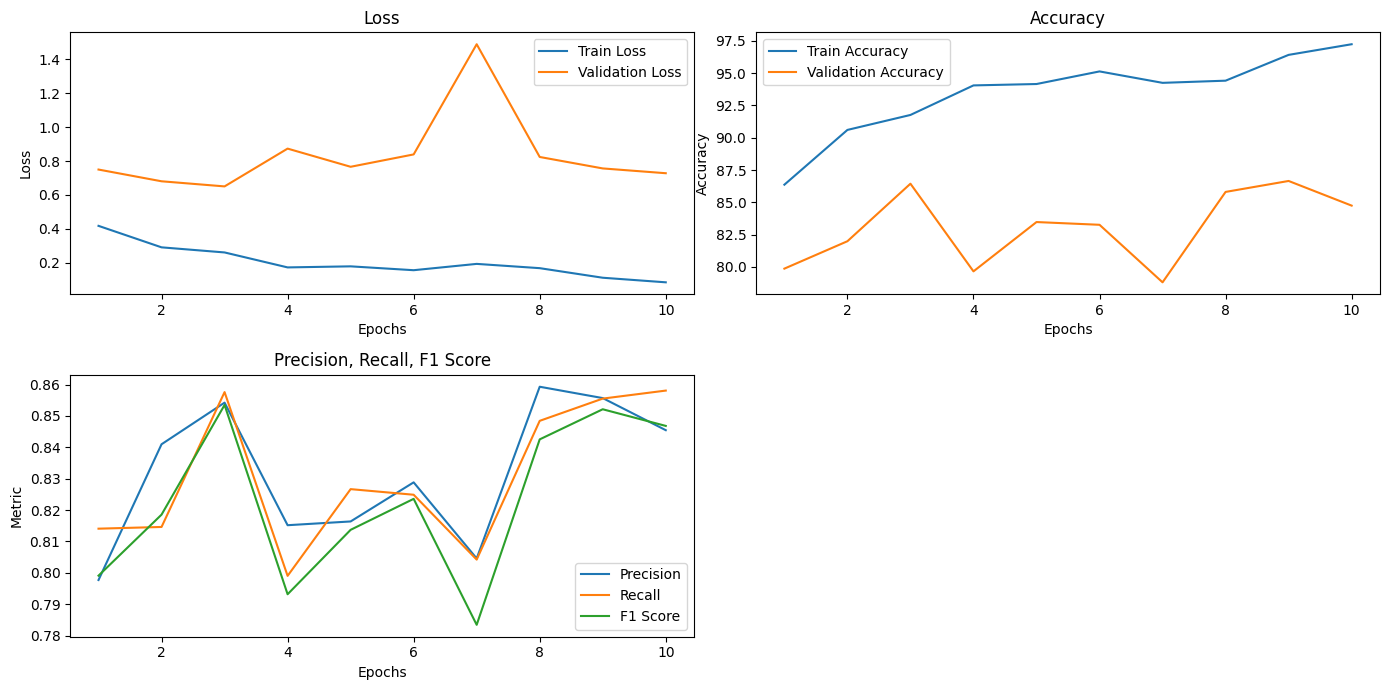

In [ ]:
# Initialize lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], [] # Initialize as two empty lists
precisions, recalls, f1s = [], [], [] # Initialize as three empty lists

epochs = 10
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    # Train
    train_loss, train_acc, train_preds, train_labels = train(model, device, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(model, device, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Calculate Precision, Recall, F1-Score
    precision, recall, f1 = calculate_metrics(val_labels, val_preds)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')

# Plot all metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, precisions, recalls, f1s)

# Save the model
torch.save(model.state_dict(), 'fish_disease_detection_model.pth')